In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
!pip install tensorboard
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms as transforms
from torchvision.transforms import functional as func_transforms
!pip install torchsummary
from torchsummary import summary

!pip install h5py matplotlib scikit-image zarr numpy pillow imgaug==0.4.0 mahotas
import h5py
from imgaug import augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
import mahotas
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import skimage.io as io
import scipy.ndimage
import scipy.special
import skimage.measure
import zarr

import datetime
import glob
import math
import os
import random
import sys

In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# if you mount your google drive
path_to_zip = '/content/drive/My\ Drive/data.zip'

In [ ]:
!unzip $path_to_zip

In [8]:
fls = glob.glob(os.path.join("data", "isbi2012", "train", "*.zarr"))
print(fls)

['data/isbi2012/train/train-volume12.zarr', 'data/isbi2012/train/train-volume4.zarr', 'data/isbi2012/train/train-volume7.zarr', 'data/isbi2012/train/train-volume29.zarr', 'data/isbi2012/train/train-volume14.zarr', 'data/isbi2012/train/train-volume22.zarr', 'data/isbi2012/train/train-volume6.zarr', 'data/isbi2012/train/train-volume18.zarr', 'data/isbi2012/train/train-volume24.zarr', 'data/isbi2012/train/train-volume21.zarr', 'data/isbi2012/train/train-volume19.zarr', 'data/isbi2012/train/train-volume17.zarr', 'data/isbi2012/train/train-volume8.zarr', 'data/isbi2012/train/train-volume1.zarr', 'data/isbi2012/train/train-volume28.zarr', 'data/isbi2012/train/train-volume27.zarr', 'data/isbi2012/train/train-volume5.zarr', 'data/isbi2012/train/train-volume2.zarr', 'data/isbi2012/train/train-volume0.zarr', 'data/isbi2012/train/train-volume15.zarr']


In [9]:
# utility functions to visualize data

def plot_image(raw, labels, pred=None):
    fig=plt.figure(figsize=(12, 8))
    if pred is not None:
        num_plots = 3
    else:
        num_plots = 2
    fig.add_subplot(1, num_plots, 1)
    plt.imshow(np.squeeze(raw), cmap='gray')
    fig.add_subplot(1, num_plots, 2)
    plt.imshow(np.squeeze(labels),cmap='gist_earth')
    if pred is not None:
        fig.add_subplot(1, num_plots, 3)
        plt.imshow(np.squeeze(pred), cmap='gist_earth')
    
def plot_random_image(type=None):
    fls = glob.glob(os.path.join("data", type, "train", "*.zarr"))
    fl = zarr.open(fls[random.randrange(len(fls))], 'r')
    raw = fl["volumes/raw"]
    if type == "isbi2012":
        labels = fl["volumes/gt_fgbg"]
    elif "dsb2018" in type:
        labels = fl["volumes/gt_threeclass"]
    else:
        raise RuntimeError("invalid type")
    plot_image(raw, labels)

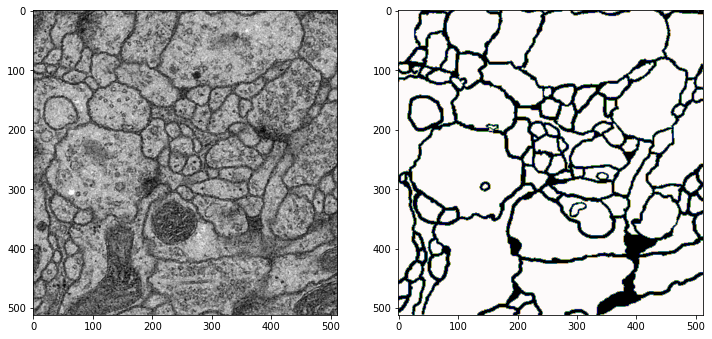

In [10]:
# plot random ISBI 2012 image
# repeatedly execute this cell to get different images
plot_random_image(type="isbi2012")

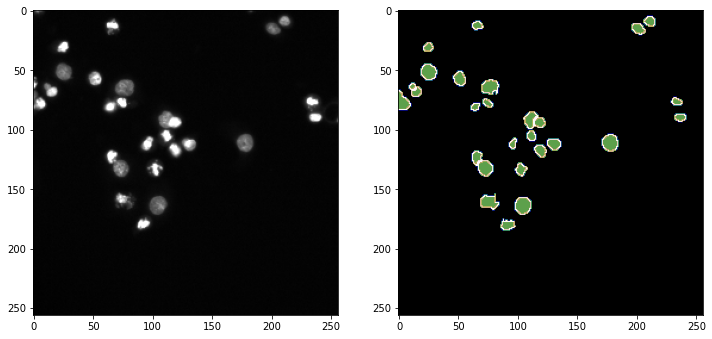

In [11]:
# plot random DBS2018 image
# repeatedly execute this cell to get different images
plot_random_image(type="dsb2018")

In [12]:
#dataset = "dsb2018"
#label_key = "volumes/gt_threeclass"

dataset = "isbi2012"
label_key = "volumes/gt_fgbg"

if "threeclass" in label_key:
    num_fmaps_out = 3
#elif "affs" in label_key:
#    num_fmaps_out = 2
else:
    num_fmaps_out = 1

In [13]:
# utility functions to convert a image, label pair of numpy arrays to pytorch tensors 

class ToTensor(object):
    def __call__(self, image, target):
        image = func_transforms.to_tensor(image)
        target = torch.as_tensor(np.asarray(target), dtype=torch.long)
        return image, target

In [14]:
class CustomDataset(Dataset):
    def __init__(self, data_root, mode="train", label_key="volumes/gt_labels", padding_size=None,
                 net_input_size=None):
        self.label_key = label_key
        self.samples = glob.glob(os.path.join(data_root, "*.zarr"))
        self.mode = mode
        self.padding_size = padding_size
        self.net_input_size = net_input_size

        self.define_augmentation()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        raw = None
        labels = None
        np.set_printoptions(threshold=100)

        print("Loading item...")
        fls = self.samples

        if torch.is_tensor(idx):
            idx = idx.tolist()

        fl = zarr.open(fls[idx], 'r')
        raw = fl["volumes/raw"]
        raw = np.squeeze(raw)

        # Augmentation to be implemented
        #if self.mode=="train":
        #  raw=augment(raw)


        labels = np.squeeze(fl[self.label_key])

        #print(labels)
 
        raw, labels = self.to_tensor(raw, labels)
        #print(f"Shape of loaded raw item:  {raw.shape}")
        #print(f"Shape of loaded label item:  {labels.shape}")

        return raw, labels
    
    def define_augmentation(self):
        self.augment = iaa.Sequential([
          iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
          iaa.Fliplr(0.5), # horizontally flip 50% of the images
          iaa.GaussianBlur(sigma=(0, 3.0)) # blur images with a sigma of 0 to 3.0
        ])
        self.crop = None
        self.pad = None

        self.to_tensor = ToTensor()

    def load_sample(self, filename):
        print("load sample")
        raw = None
        labels = None

        return raw, labels
    
    def pad_sample(self, raw, labels):
        if self.pad is not None:
            if labels is None:
                raw = self.pad(image=raw)
            else:
                labels = SegmentationMapsOnImage(labels, shape=raw.shape)
                raw, labels = self.pad(image=raw, segmentation_maps=labels)
                labels = labels.get_arr()
        return raw, labels
    
    def crop_sample(self, raw, labels):
        if self.crop is not None:
            labels = SegmentationMapsOnImage(labels, shape=raw.shape)
            raw, labels = self.crop(image=raw, segmentation_maps=labels)
            labels = labels.get_arr()
        return raw, labels
    
    def augment_sample(self, raw, labels):
        # this code makes sure that the same geometric augmentations are applied
        # to both the raw image and the label image
        labels = SegmentationMapsOnImage(labels, shape=raw.shape)
        raw, labels = self.transform(image=raw, segmentation_maps=labels)
        labels = labels.get_arr()

        # some pytorch version have problems with negative indices introduced by e.g. flips
        # just copying fixes this
        labels = labels.copy()
        raw = raw.copy()
        
        return raw, labels

In [15]:
tmp_data = CustomDataset(os.path.join("data", dataset, "train"), 
                         mode="train", label_key="volumes/gt_labels")
tmp_loader = DataLoader(tmp_data, batch_size=1, shuffle=True)

dataiter = iter(tmp_loader)

Loading item...
torch.Size([1, 1, 512, 512]) torch.Size([1, 512, 512])
tensor([[[  1,   1,   1,  ...,   9,   9,   9],
         [  1,   1,   1,  ...,   9,   9,   9],
         [  1,   1,   1,  ...,   9,   9,   9],
         ...,
         [134, 134, 134,  ..., 129, 129, 129],
         [134, 134, 134,  ..., 129, 129, 129],
         [134, 134, 134,  ..., 129, 129, 129]]])


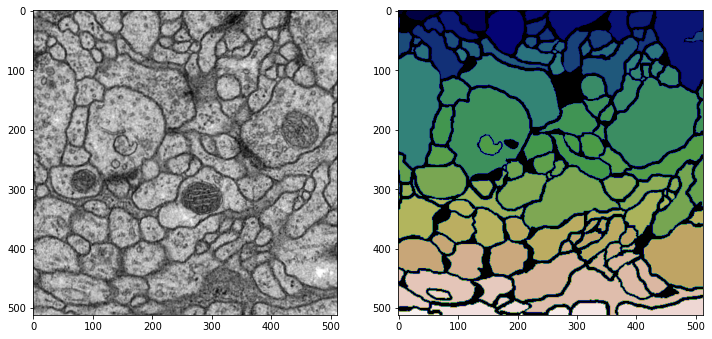

In [16]:
# repeatedly execute this cell
image, label = next(dataiter)
print(image.shape, label.shape)
print(label)
plot_image(image, label)

## UNET

In [17]:
class Downsample(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(1, 64, 3, stride=1, padding=1), torch.nn.ReLU(), torch.nn.Conv2d(64, 64, 3, stride=1, padding=1), torch.nn.ReLU())
    self.conv2 = torch.nn.Sequential(torch.nn.Conv2d(64, 128, 3, stride=1, padding=1), torch.nn.ReLU(), torch.nn.Conv2d(128, 128, 3, stride=1, padding=1), torch.nn.ReLU())
    self.conv3 = torch.nn.Sequential(torch.nn.Conv2d(128, 256, 3, stride=1, padding=1), torch.nn.ReLU(), torch.nn.Conv2d(256, 256, 3, stride=1, padding=1), torch.nn.ReLU())
    self.conv4 = torch.nn.Sequential(torch.nn.Conv2d(256, 512, 3, stride=1, padding=1), torch.nn.ReLU(), torch.nn.Conv2d(512, 512, 3, stride=1, padding=1), torch.nn.ReLU())
    self.conv5 = torch.nn.Sequential(torch.nn.Conv2d(512, 1024, 3, stride=1, padding=1), torch.nn.ReLU(), torch.nn.Conv2d(1024, 1024, 3, stride=1, padding=1), torch.nn.ReLU())
    self.down_sample = torch.nn.MaxPool2d(2, stride=2)

  def forward(self, input):
    layer_1 = self.conv1(input)
    layer_2 = self.conv2(self.down_sample(layer_1))
    layer_3 = self.conv3(self.down_sample(layer_2))
    layer_4 = self.conv4(self.down_sample(layer_3))
    layer_5 = self.conv5(self.down_sample(layer_4))
    
    return layer_1, layer_2, layer_3, layer_4, layer_5 

    

class Upsample(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_6 = torch.nn.Sequential(torch.nn.Conv2d((512 + 1024), 512, 3, stride=1, padding=1), torch.nn.ReLU(), torch.nn.Conv2d(512, 512, 3, stride=1, padding=1), torch.nn.ReLU())
    self.conv_7 = torch.nn.Sequential(torch.nn.Conv2d((256 + 512), 256, 3, stride=1, padding=1), torch.nn.ReLU(), torch.nn.Conv2d(256, 256, 3, stride=1, padding=1), torch.nn.ReLU())
    self.conv_8 = torch.nn.Sequential(torch.nn.Conv2d((128 + 256), 128, 3, stride=1, padding=1), torch.nn.ReLU(), torch.nn.Conv2d(128, 128, 3, stride=1, padding=1), torch.nn.ReLU())
    self.conv_9 = torch.nn.Sequential(torch.nn.Conv2d((64 + 128), 64, 3, stride=1, padding=1), torch.nn.ReLU(), torch.nn.Conv2d(64, 64, 3, stride=1, padding=1), torch.nn.ReLU())
    #self.conv_10 = torch.nn.Sequential(torch.nn.Conv2d(64, num_fmaps_out, 1, stride=1, padding=0))#, torch.nn.Sigmoid())
    self.conv_10 = torch.nn.Conv2d(64, num_fmaps_out, 1)

    self.upsample = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
  
  def forward(self, skip_input1, skip_input2, skip_input3, skip_input4, skip_input5):
    #print(self.upsample(skip_input1).shape)
    #print(skip_input1.shape)
    #print(skip_input2.shape)
    layer_6 = torch.cat([self.upsample(skip_input1), skip_input2], dim=1)
    layer_6 = self.conv_6(layer_6)

    layer_7 = torch.cat([self.upsample(layer_6), skip_input3], dim=1)
    layer_7 = self.conv_7(layer_7)

    layer_8 = torch.cat([self.upsample(layer_7), skip_input4], dim=1)
    layer_8 = self.conv_8(layer_8)

    layer_9 = torch.cat([self.upsample(layer_8), skip_input5], dim=1)
    layer_9 = self.conv_9(layer_9)

    layer_10 = self.conv_10(layer_9)

    return layer_10



class UNet(torch.nn.Module):

    def __init__(self):
      # create layers etc
      super().__init__()
      self.contraction = Downsample()
      self.expansion = Upsample()
        
    #def ...

    def get_fov(self):
        fov = None
        return fov
    

    def forward(self, x):
        
        layer_1, layer_2, layer_3, layer_4, layer_5 = self.contraction(x)
        y = self.expansion(layer_5, layer_4, layer_3, layer_2, layer_1)

        return y

In [18]:
net_in_size = (1, 512, 512)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet()
model = model.to(device)

from torchsummary import summary
summary(model, input_size=net_in_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]             640
              ReLU-2         [-1, 64, 512, 512]               0
            Conv2d-3         [-1, 64, 512, 512]          36,928
              ReLU-4         [-1, 64, 512, 512]               0
         MaxPool2d-5         [-1, 64, 256, 256]               0
            Conv2d-6        [-1, 128, 256, 256]          73,856
              ReLU-7        [-1, 128, 256, 256]               0
            Conv2d-8        [-1, 128, 256, 256]         147,584
              ReLU-9        [-1, 128, 256, 256]               0
        MaxPool2d-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]         295,168
             ReLU-12        [-1, 256, 128, 128]               0
           Conv2d-13        [-1, 256, 128, 128]         590,080
             ReLU-14        [-1, 256, 1